# TFX on TF2 Vertex Pipelines
Author - Hasan Rafiq, Google

This notebook is a stepwise guide to build and deploy a TFX pipeline on TFX on TF2 and deploy on GCP and Local.

### Execution modes:
- TFX Pipeline - Interactive mode
- Test on Local mode
- Deploy on GCP

### Library versions:
- TFX 1.12.0
- TF 2.11.0

In [125]:
!pip install --user tfx==1.12.0
!pip install --user ipywidgets==8.0.4
!pip install --user witwidget
!pip install --user kfp==1.8.4

  Using cached ipywidgets-7.7.3-py2.py3-none-any.whl (123 kB)
  Using cached jupyterlab_widgets-1.1.2-py3-none-any.whl (245 kB)
  Using cached widgetsnbextension-3.6.2-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab-widgets 3.0.5
    Uninstalling jupyterlab-widgets-3.0.5:
      Successfully uninstalled jupyterlab-widgets-3.0.5
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 4.0.5
    Uninstalling widgetsnbextension-4.0.5:
      Successfully uninstalled widgetsnbextension-4.0.5
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 8.0.4
    Uninstalling ipywidgets-8.0.4:
      Successfully uninstalled ipywidgets-8.0.4
  Using cached ipywidgets-8.0.4-py3-none-any.whl (137 kB)
  Using cached widgetsnbextension-4.0.5-py3-none-any.whl (2.0 MB)
  Using cached jupyterlab_widgets-3.0.5-py3-none-any.whl (384 kB)
  Attempting uninstall: widgetsnbextension
 

## Build Pipeline - Interactive mode

In [75]:
import os
import pprint
import numpy as np
import tempfile
import urllib

import absl
import pandas as pd
import tensorflow as tf
import tensorflow_model_analysis as tfma
tf.get_logger().propagate = False
pp = pprint.PrettyPrinter()

import tfx
from google.protobuf.json_format import MessageToDict
from tfx.components import CsvExampleGen
# from tfx.components.common_nodes.importer_node import ImporterNode
from typing import Dict, List, Text
from tfx.components import Evaluator, ExampleValidator, Pusher, SchemaGen, StatisticsGen, Transform, Tuner, Trainer
from tfx.dsl.components.base import executor_spec
from tfx.components.trainer.executor import GenericExecutor
from tfx.dsl.experimental import latest_blessed_model_resolver
from tfx.orchestration import metadata, pipeline
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
from tfx.proto import pusher_pb2, trainer_pb2, tuner_pb2, example_gen_pb2
from tfx.types import Channel
from tfx.types.standard_artifacts import Model, ModelBlessing, HyperParameters
from tfx.types import Channel
# from tfx.utils.dsl_utils import external_input

from tfx.extensions.google_cloud_ai_platform.trainer import component as gcp_trainer
from tfx.extensions.google_cloud_ai_platform.tuner import component as gcp_tuner
from tfx.extensions.google_cloud_ai_platform.pusher import component as gcp_pusher
from tfx.extensions.google_cloud_ai_platform.constants import ENABLE_VERTEX_KEY
from tfx.extensions.google_cloud_ai_platform.constants import VERTEX_REGION_KEY
import hypertune

# from tensorflow_cloud import CloudTuner

%load_ext tfx.orchestration.experimental.interactive.notebook_extensions.skip

The tfx.orchestration.experimental.interactive.notebook_extensions.skip extension is already loaded. To reload it, use:
  %reload_ext tfx.orchestration.experimental.interactive.notebook_extensions.skip


In [76]:
print('TensorFlow version: {}'.format(tf.__version__))
print('TFX version: {}'.format(tfx.__version__))

TensorFlow version: 2.11.0
TFX version: 1.12.0


In [77]:
# Create TFX required directories
!rm -rf *
!rm -rf data.*
!rm -rf *trainer.py
!sudo rm -rf tfx/*

! mkdir tfx
! mkdir tfx/pipelines
! mkdir tfx/metadata
! mkdir tfx/logs
! mkdir tfx/data
! mkdir tfx/serving_model

In [78]:
!wget https://raw.githubusercontent.com/rafiqhasan/AI_DL_ML_Repo/master/Datasets/GRIR/data.csv

--2023-02-23 11:42:50--  https://raw.githubusercontent.com/rafiqhasan/AI_DL_ML_Repo/master/Datasets/GRIR/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 355446 (347K) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>] 347.12K  --.-KB/s    in 0.02s   

2023-02-23 11:42:50 (14.3 MB/s) - ‘data.csv’ saved [355446/355446]



In [79]:
df = pd.read_csv('data.csv')

##Drop useless columns
df = df.drop([], axis=1)

#Drop NA rows
df = df.dropna()

df.to_csv("tfx/data/data_trans.csv", index=False, header=True)

In [80]:
%%bash
#Copy data data on GCS
PROJECT_ID="aojn-cloudfest-hasan" ##PROJECT - ID
BUCKET_NAME="gs://gcs-${PROJECT_ID}"

gsutil mb ${BUCKET_NAME}
gsutil cp tfx/data/data_trans.csv ${BUCKET_NAME}/tfx/taxi/data/

Creating gs://gcs-aojn-cloudfest-hasan/...
ServiceException: 409 A Cloud Storage bucket named 'gcs-aojn-cloudfest-hasan' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.
Copying file://tfx/data/data_trans.csv [Content-Type=text/csv]...
/ [1 files][339.0 KiB/339.0 KiB]                                                
Operation completed over 1 objects/339.0 KiB.                                    


In [81]:
##Define all constant
_tfx_root = os.path.join(os.getcwd(), 'tfx');        # Create location ~/tfx
_pipeline_root = os.path.join(_tfx_root, 'pipelines');      # Join ~/tfx/pipelines/
_metadata_db_root = os.path.join(_tfx_root, 'metadata.db');    # Join ~/tfx/metadata.db
_log_root = os.path.join(_tfx_root, 'logs');
_model_root = os.path.join(_tfx_root, 'model');
_data_root = os.path.join(_tfx_root, 'data');
_serving_model_dir = os.path.join(_tfx_root, 'serving_model')
_data_filepath = os.path.join(_data_root, "data_trans.csv")

_transform_module_file = 'transform.py'
_model_trainer_module_file = 'model.py'

### First run in Interactive context

In [82]:
# Here, we create an InteractiveContext using default parameters. This will
# use a temporary directory with an ephemeral ML Metadata database instance.
# To use your own pipeline root or database, the optional properties
# `pipeline_root` and `metadata_connection_config` may be passed to
# InteractiveContext. Calls to InteractiveContext are no-ops outside of the
# notebook.
context = InteractiveContext(pipeline_root=_tfx_root)

In [83]:
output = example_gen_pb2.Output(
             split_config=example_gen_pb2.SplitConfig(splits=[
                 example_gen_pb2.SplitConfig.Split(name='train', hash_buckets=45),
                 example_gen_pb2.SplitConfig.Split(name='eval', hash_buckets=5)
             ]))

example_gen = CsvExampleGen(_data_root, output_config=output)
context.run(example_gen)

ExecutionResult(
    component_id: CsvExampleGen
    execution_id: 1
    outputs:
        examples: OutputChannel(artifact_type=Examples, producer_component_id=CsvExampleGen, output_key=examples, additional_properties={}, additional_custom_properties={}))

In [84]:
### START CODE HERE
# Instantiate StatisticsGen with the ExampleGen ingested dataset
statistics_gen = StatisticsGen(examples=example_gen.outputs['examples'])
context.run(statistics_gen)

ExecutionResult(
    component_id: StatisticsGen
    execution_id: 2
    outputs:
        statistics: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=StatisticsGen, output_key=statistics, additional_properties={}, additional_custom_properties={}))

In [85]:
# Plot the statistics generated
context.show(statistics_gen.outputs['statistics'])

In [86]:
### START CODE HERE
# Instantiate SchemaGen with the output statistics from the StatisticsGen
schema_gen = SchemaGen(statistics=statistics_gen.outputs['statistics'], 
                       infer_feature_shape=False) ##Keep this FALSE
    
# Run the component
context.run(schema_gen)
### END CODE HERE

ExecutionResult(
    component_id: SchemaGen
    execution_id: 3
    outputs:
        schema: OutputChannel(artifact_type=Schema, producer_component_id=SchemaGen, output_key=schema, additional_properties={}, additional_custom_properties={}))

In [87]:
# Visualize the output
context.show(schema_gen.outputs['schema'])

,Type,Presence,Valency,Domain
Feature name,,,,
'DIFGRIRD',INT,required,single,-
'DIFGRIRV',INT,required,single,-
'EKGRP',STRING,required,single,'EKGRP'
'EKORG',INT,required,single,-
'KTOKK',INT,required,single,-
'NODLGR',INT,required,single,-
'NODLIR',INT,required,single,-
'SCENARIO',INT,required,single,-
'STATUS',INT,required,single,-


,Values
Domain,
'EKGRP',"'A', 'B', 'C'"
'WERKS',"'ML01', 'ML02', 'ML03'"


In [88]:
### START CODE HERE
# Instantiate ExampleValidator with the statistics and schema from the previous steps
example_validator = ExampleValidator(statistics=statistics_gen.outputs['statistics'],
                              schema=schema_gen.outputs['schema'])
    
# Run the component
context.run(example_validator)
### END CODE HERE

ExecutionResult(
    component_id: ExampleValidator
    execution_id: 4
    outputs:
        anomalies: OutputChannel(artifact_type=ExampleAnomalies, producer_component_id=ExampleValidator, output_key=anomalies, additional_properties={}, additional_custom_properties={}))

In [89]:
# Visualize the output
context.show(example_validator.outputs['anomalies'])

#### Transform component

In [90]:
%%writefile {_transform_module_file}

# Features to be scaled to the z-score
_DENSE_FLOAT_FEATURE_KEYS = ['TOTGRQTY', 'TOTIRQTY', 'NODLGR', 'NODLIR', 'DIFGRIRD' , 'DIFGRIRV']

# WERKS,SCENARIO,KTOKK,VSTATU,VPATD,EKORG,EKGRP,TOTGRQTY,TOTIRQTY,NODLGR,NODLIR,DIFGRIRD,DIFGRIRV,STATUS

# Features to bucketize
_BUCKET_FEATURE_KEYS = []

_FEATURE_BUCKET_COUNT = {
}

# Number of vocabulary terms used for encoding VOCAB_FEATURES by tf.transform
_VOCAB_SIZE = 1000

# Count of out-of-vocab buckets in which unrecognized VOCAB_FEATURES are hashed.
_OOV_SIZE = 10

# Features with string data types that will be converted to indices
_VOCAB_FEATURE_KEYS = [
    'WERKS', 
    'SCENARIO',
    'KTOKK', 
    'VSTATU',
    'VPATD',
    'EKORG',
    'EKGRP'
]

# Features with int data type that will be kept as is
_CATEGORICAL_FEATURE_KEYS = [
]

# Feature to predict
_LABEL_KEY = 'STATUS'

def _transformed_name(key):
    return key

Writing transform.py


In [91]:
%%writefile -a {_transform_module_file}

import tensorflow as tf
import tensorflow_transform as tft

def preprocessing_fn(inputs):
    """tf.transform's callback function for preprocessing inputs.
    Args:
        inputs: map from feature keys to raw not-yet-transformed features.
    Returns:
        Map from string feature key to transformed feature operations.
    """
    outputs = {}
    
    # Required as TF2 has issues with TFT, mentioned in documentation - 
    # https://tensorflow.google.cn/tfx/transform/tf2_support#retaining_the_legacy_tftransform_behavior
    
    ### START CODE HERE
    # Scale these features to the z-score.
    for key in _DENSE_FLOAT_FEATURE_KEYS:
        # Scale these features to the z-score.
        outputs[_transformed_name(key)] = tft.scale_to_z_score(_fill_in_missing(inputs[key]))

    # Scale these feature/s from 0 to 1
    # for key in _RANGE_FEATURE_KEYS:
    #     outputs[_transformed_name(key)] = tft.scale_to_0_1(inputs[key])

    # Transform the strings into indices 
    # hint: use the VOCAB_SIZE and OOV_SIZE to define the top_k and num_oov parameters
    for key in _VOCAB_FEATURE_KEYS:
        outputs[_transformed_name(key)] = tft.compute_and_apply_vocabulary(_fill_in_missing(inputs[key]), 
                                                                           top_k=_VOCAB_SIZE, 
                                                                           num_oov_buckets=_OOV_SIZE,
                                                                           vocab_filename=key)

    # Bucketize the feature
    for key in _BUCKET_FEATURE_KEYS:
        outputs[_transformed_name(key)] = tft.bucketize(_fill_in_missing(inputs[key]), num_buckets=_FEATURE_BUCKET_COUNT[key])

    # Keep inputs as is. No tft function needed.
    for key in _CATEGORICAL_FEATURE_KEYS:
        outputs[_transformed_name(key)] = _fill_in_missing(inputs[key])

    # Use `tf.cast` to cast the label key to float32 and fill in the missing values.
    outputs[_transformed_name(_LABEL_KEY)] = _fill_in_missing(inputs[_LABEL_KEY])

    #Feat Engg: New features
    # outputs['distance'] = tf.pow(tf.cast((outputs['pickup_latitude'] - outputs['dropoff_latitude'])**2 + (outputs['pickup_longitude'] - outputs['dropoff_longitude'])**2, tf.float32), 0.5)

    ### END CODE HERE
    return outputs


def _fill_in_missing(x):
    """Replace missing values in a SparseTensor.
    Fills in missing values of `x` with '' or 0, and converts to a dense tensor.
    Args:
    x: A `SparseTensor` of rank 2.  Its dense shape should have size at most 1
      in the second dimension.
    Returns:
    A rank 1 tensor where missing values of `x` have been filled in.
    """
    
    if not isinstance(x, tf.sparse.SparseTensor):
        return x

    default_value = '' if x.dtype == tf.string else 0
    return tf.squeeze(
      tf.sparse.to_dense(
          tf.SparseTensor(x.indices, x.values, [x.dense_shape[0], 1]),
          default_value),
      axis=1)

Appending to transform.py


In [92]:
### START CODE HERE
# Instantiate the Transform component
transform = Transform(
    examples=example_gen.outputs['examples'],
    schema=schema_gen.outputs['schema'],
    force_tf_compat_v1=True,  ##Disable TF2 behavior as currently there are issues when we run on DataFlowRunner
    module_file=os.path.abspath(_transform_module_file))
    
# Run the component.
# The `enable_cache` flag is disabled in case you need to update your transform module file.
context.run(transform, enable_cache=False)

running bdist_wheel
running build
running build_py
creating build
creating build/lib
copying transform.py -> build/lib
installing to /var/tmp/tmp028mmxfr
running install
running install_lib
copying build/lib/transform.py -> /var/tmp/tmp028mmxfr
running install_egg_info
running egg_info
creating tfx_user_code_Transform.egg-info
writing tfx_user_code_Transform.egg-info/PKG-INFO
writing dependency_links to tfx_user_code_Transform.egg-info/dependency_links.txt
writing top-level names to tfx_user_code_Transform.egg-info/top_level.txt
writing manifest file 'tfx_user_code_Transform.egg-info/SOURCES.txt'
reading manifest file 'tfx_user_code_Transform.egg-info/SOURCES.txt'
writing manifest file 'tfx_user_code_Transform.egg-info/SOURCES.txt'
Copying tfx_user_code_Transform.egg-info to /var/tmp/tmp028mmxfr/tfx_user_code_Transform-0.0+fd5f8830c0c17521ae6678e06d8ecd36b8a968c9cbce14c4d27e1140f997c763-py3.7.egg-info
running install_scripts
creating /var/tmp/tmp028mmxfr/tfx_user_code_Transform-0.0+fd5

/opt/conda/lib/python3.7/site-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,


Processing ./tfx/_wheels/tfx_user_code_Transform-0.0+fd5f8830c0c17521ae6678e06d8ecd36b8a968c9cbce14c4d27e1140f997c763-py3-none-any.whl


Processing ./tfx/_wheels/tfx_user_code_Transform-0.0+fd5f8830c0c17521ae6678e06d8ecd36b8a968c9cbce14c4d27e1140f997c763-py3-none-any.whl


Processing ./tfx/_wheels/tfx_user_code_Transform-0.0+fd5f8830c0c17521ae6678e06d8ecd36b8a968c9cbce14c4d27e1140f997c763-py3-none-any.whl


INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'Counter' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'tuple' object has no attribute 'name'
INFO:tensorflow:SavedModel written to: /home/jupyter/tfx/Transform/transform_graph/5/.temp_path/tftransform_tmp/fabd29aa1f6f4cb7860c49e8f6212f5e/saved_model.pb
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'Counter' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'tuple' o

INFO:tensorflow:struct2tensor is not available.
INFO:tensorflow:tensorflow_decision_forests is not available.
INFO:tensorflow:tensorflow_text is not available.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:struct2tensor is not available.
INFO:tensorflow:tensorflow_decision_forests is not available.
INFO:tensorflow:tensorflow_text is not available.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:Assets written to: /home/jupyter/tfx/Transform/transform_graph/5/.temp_path/tftransform_tmp/b5d5155624ef4da495543ad9b26c0523/assets
INFO:tensorflow:SavedModel written to: /home/jupyter/tfx/Transform/transform_graph/5/.temp_path/tftransform_tmp/b5d5155624ef4da495543ad9b26c0523/saved_model.pb
INFO:tensorflow:struct2tensor is not available.
INFO:tensorflow:tensorflow_decision_forests is not available.
INFO:tensorflow:tensorflow_text is not availa

2023-02-23 11:43:52.160904: W tensorflow/c/c_api.cc:291] Operation '{name:'transform/transform/compute_and_apply_vocabulary_6/apply_vocab/text_file_init/InitializeTableFromTextFileV2' id:625 op device:{requested: '', assigned: ''} def:{{{node transform/transform/compute_and_apply_vocabulary_6/apply_vocab/text_file_init/InitializeTableFromTextFileV2}} = InitializeTableFromTextFileV2[_has_manual_control_dependencies=true, delimiter="\t", key_index=-2, offset=0, value_index=-1, vocab_size=-1](transform/transform/compute_and_apply_vocabulary_6/apply_vocab/hash_table, Const_6:0)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


INFO:tensorflow:struct2tensor is not available.
INFO:tensorflow:tensorflow_decision_forests is not available.
INFO:tensorflow:tensorflow_text is not available.
value: "\n\013\n\tConst_4:0\022\005WERKS"

value: "\n\013\n\tConst_7:0\022\010SCENARIO"

value: "\n\014\n\nConst_10:0\022\005KTOKK"

value: "\n\014\n\nConst_13:0\022\006VSTATU"

value: "\n\014\n\nConst_16:0\022\005VPATD"

value: "\n\014\n\nConst_19:0\022\005EKORG"

value: "\n\014\n\nConst_22:0\022\005EKGRP"

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2023-02-23 11:43:52.685480: W tensorflow/c/c_api.cc:291] Operation '{name:'transform/transform/compute_and_apply_vocabulary_6/apply_vocab/text_file_init/InitializeTableFromTextFileV2' id:625 op device:{requested: '', assigned: ''} def:{{{node transform/transform/compute_and_apply_vocabulary_6/apply_vocab/text_file_init/InitializeTableFromTextFileV2}} = InitializeTableFromTextFileV2[_has_manual_control_dependencies=true, delimiter="\t", key_index=-2, offset=0, value_index=-1, vocab_size=-1](transform/transform/compute_and_apply_vocabulary_6/apply_vocab/hash_table, Const_6:0)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


INFO:tensorflow:struct2tensor is not available.
INFO:tensorflow:tensorflow_decision_forests is not available.
INFO:tensorflow:tensorflow_text is not available.
value: "\n\013\n\tConst_4:0\022\005WERKS"

value: "\n\013\n\tConst_7:0\022\010SCENARIO"

value: "\n\014\n\nConst_10:0\022\005KTOKK"

value: "\n\014\n\nConst_13:0\022\006VSTATU"

value: "\n\014\n\nConst_16:0\022\005VPATD"

value: "\n\014\n\nConst_19:0\022\005EKORG"

value: "\n\014\n\nConst_22:0\022\005EKGRP"

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2023-02-23 11:43:53.385465: W tensorflow/c/c_api.cc:291] Operation '{name:'transform/transform/compute_and_apply_vocabulary_6/apply_vocab/text_file_init/InitializeTableFromTextFileV2' id:625 op device:{requested: '', assigned: ''} def:{{{node transform/transform/compute_and_apply_vocabulary_6/apply_vocab/text_file_init/InitializeTableFromTextFileV2}} = InitializeTableFromTextFileV2[_has_manual_control_dependencies=true, delimiter="\t", key_index=-2, offset=0, value_index=-1, vocab_size=-1](transform/transform/compute_and_apply_vocabulary_6/apply_vocab/hash_table, Const_6:0)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


ExecutionResult(
    component_id: Transform
    execution_id: 5
    outputs:
        transform_graph: OutputChannel(artifact_type=TransformGraph, producer_component_id=Transform, output_key=transform_graph, additional_properties={}, additional_custom_properties={})
        transformed_examples: OutputChannel(artifact_type=Examples, producer_component_id=Transform, output_key=transformed_examples, additional_properties={}, additional_custom_properties={})
        updated_analyzer_cache: OutputChannel(artifact_type=TransformCache, producer_component_id=Transform, output_key=updated_analyzer_cache, additional_properties={}, additional_custom_properties={})
        pre_transform_schema: OutputChannel(artifact_type=Schema, producer_component_id=Transform, output_key=pre_transform_schema, additional_properties={}, additional_custom_properties={})
        pre_transform_stats: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=Transform, output_key=pre_transform_stats, additional_properties={}, additional_custom_properties={})
        post_transform_schema: OutputChannel(artifact_type=Schema, producer_component_id=Transform, output_key=post_transform_schema, additional_properties={}, additional_custom_properties={})
        post_transform_stats: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=Transform, output_key=post_transform_stats, additional_properties={}, additional_custom_properties={})
        post_transform_anomalies: OutputChannel(artifact_type=ExampleAnomalies, producer_component_id=Transform, output_key=post_transform_anomalies, additional_properties={}, additional_custom_properties={}))

In [93]:
##Examine the transformed data
def get_records(dataset, num_records):
    '''Extracts records from the given dataset.
    Args:
        dataset (TFRecordDataset): dataset saved by ExampleGen
        num_records (int): number of records to preview
    '''
    
    # initialize an empty list
    records = []

    ### START CODE HERE
    # Use the `take()` method to specify how many records to get
    for tfrecord in dataset.take(num_records):
        
        # Get the numpy property of the tensor
        serialized_example = tfrecord.numpy()
        
        # Initialize a `tf.train.Example()` to read the serialized data
        example = tf.train.Example()
        
        # Read the example data (output is a protocol buffer message)
        example.ParseFromString(serialized_example)
        
        # convert the protocol bufffer message to a Python dictionary
        example_dict = MessageToDict(example)
        
        # append to the records list
        records.append(example_dict)
        
    ### END CODE HERE
    return records

try:
    # Get the URI of the output artifact representing the transformed examples
    train_uri = os.path.join(transform.outputs['transformed_examples'].get()[0].uri, 'Split-train')
    
except IndexError:
    print("context.run() was no-op")
    train_uri = os.path.join(transform_graph_uri, 'train')
    
# Get the list of files in this directory (all compressed TFRecord files)
tfrecord_filenames = [os.path.join(train_uri, name)
                      for name in os.listdir(train_uri)]

# Create a `TFRecordDataset` to read these files
transformed_dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")
# Get 3 records from the dataset
sample_records_xf = get_records(transformed_dataset, 3)

# Print the output
pp.pprint(sample_records_xf)

[{'features': {'feature': {'DIFGRIRD': {'floatList': {'value': [-0.82704693]}},
                           'DIFGRIRV': {'floatList': {'value': [-1.3751652]}},
                           'EKGRP': {'int64List': {'value': ['2']}},
                           'EKORG': {'int64List': {'value': ['0']}},
                           'KTOKK': {'int64List': {'value': ['0']}},
                           'NODLGR': {'floatList': {'value': [-1.2625594]}},
                           'NODLIR': {'floatList': {'value': [0.0054792915]}},
                           'SCENARIO': {'int64List': {'value': ['1']}},
                           'STATUS': {'int64List': {'value': ['1']}},
                           'TOTGRQTY': {'floatList': {'value': [-1.0518184]}},
                           'TOTIRQTY': {'floatList': {'value': [-0.22588593]}},
                           'VPATD': {'int64List': {'value': ['2']}},
                           'VSTATU': {'int64List': {'value': ['0']}},
                           'WERKS': {'

#### Trainer component

In [132]:
%%writefile {_model_trainer_module_file}

"""WideDeep Classifier."""
import functools
import absl
import os
from typing import List, Text

import kerastuner
from keras_tuner.engine import hyperparameters as hp_module
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_transform as tft

from tfx.components.trainer.executor import TrainerFnArgs
from tfx.components.trainer.fn_args_utils import DataAccessor
from tfx.components.tuner.component import TunerFnResult
from tfx_bsl.tfxio import dataset_options

LABEL_KEY = 'STATUS'
TRAIN_BATCH_SIZE = 128
EVAL_BATCH_SIZE = 512
BUCKET_SIZE = 30
_FEATURE_KEYS = ['TOTGRQTY', 
                 'TOTIRQTY', 
                 'NODLGR', 
                 'NODLIR', 
                 'DIFGRIRD' , 
                 'DIFGRIRV',
                 'WERKS', 
                'SCENARIO',
                'KTOKK', 
                'VSTATU',
                'VPATD',
                'EKORG',
                'EKGRP']
categorical_fields = ['WERKS', 
                'SCENARIO',
                'KTOKK', 
                'VSTATU',
                'VPATD',
                'EKORG',
                'EKGRP']
_LABEL_KEY = LABEL_KEY

# Define feature columns(Including feature engineered ones )
# These are the features which come from the TF Data pipeline
def create_feature_cols():
    #Keras format features
    k_TOTGRQTY = tf.keras.Input(name='TOTGRQTY', shape=(1,), dtype=tf.float32, sparse=False)
    k_TOTIRQTY  = tf.keras.Input(name='TOTIRQTY', shape=(1,), dtype=tf.float32, sparse=False)
    k_NODLGR  = tf.keras.Input(name='NODLGR', shape=(1,), dtype=tf.float32, sparse=False)
    k_NODLIR  = tf.keras.Input(name='NODLIR', shape=(1,), dtype=tf.float32, sparse=False)
    k_DIFGRIRD  = tf.keras.Input(name='DIFGRIRD', shape=(1,), dtype=tf.float32, sparse=False)
    k_DIFGRIRV  = tf.keras.Input(name='DIFGRIRV', shape=(1,), dtype=tf.float32, sparse=False)
    k_WERKS  = tf.keras.Input(name='WERKS', shape=(1,), dtype=tf.int32, sparse=False)
    k_SCENARIO  = tf.keras.Input(name='SCENARIO', shape=(1,), dtype=tf.int32, sparse=False)
    k_KTOKK  = tf.keras.Input(name='KTOKK', shape=(1,), dtype=tf.int32, sparse=False)
    k_VSTATU  = tf.keras.Input(name='VSTATU', shape=(1,), dtype=tf.int32, sparse=False)
    k_VPATD  = tf.keras.Input(name='VPATD', shape=(1,), dtype=tf.int32, sparse=False)
    k_EKORG  = tf.keras.Input(name='EKORG', shape=(1,), dtype=tf.int32, sparse=False)
    k_EKGRP  = tf.keras.Input(name='EKGRP', shape=(1,), dtype=tf.int32, sparse=False)
    
    keras_dict_input = {'TOTGRQTY': k_TOTGRQTY, 'TOTIRQTY': k_TOTIRQTY, 'NODLGR' : k_NODLGR,
                        'NODLIR': k_NODLIR, 'DIFGRIRD': k_DIFGRIRD,
                        'DIFGRIRV': k_DIFGRIRV, 'WERKS': k_WERKS, 'SCENARIO' : k_SCENARIO,
                        'KTOKK' : k_KTOKK , 'VSTATU': k_VSTATU, 'VPATD': k_VPATD, 'EKORG' : k_EKORG,
                        'EKGRP' : k_EKGRP
                        }

    return({'K' : keras_dict_input})

def _input_fn(file_pattern: List[Text],
              data_accessor: DataAccessor,
              tf_transform_output: tft.TFTransformOutput,
              batch_size: int = 200) -> tf.data.Dataset:
  """Generates features and label for tuning/training.
  Args:
    file_pattern: List of paths or patterns of input tfrecord files.
    data_accessor: DataAccessor for converting input to RecordBatch.
    tf_transform_output: A TFTransformOutput.
    batch_size: representing the number of consecutive elements of returned
      dataset to combine in a single batch
  Returns:
    A dataset that contains (features, indices) tuple where features is a
      dictionary of Tensors, and indices is a single Tensor of label indices.
  """
  dataset = data_accessor.tf_dataset_factory(
      file_pattern,
      dataset_options.TensorFlowDatasetOptions(
          batch_size=batch_size, label_key=LABEL_KEY),
      tf_transform_output.transformed_metadata.schema)
    
  return dataset

# TFX Tuner will call this function.
def tuner_fn(fn_args: TrainerFnArgs) -> TunerFnResult:
  """Build the tuner using the KerasTuner API.
  Args:
    fn_args: Holds args as name/value pairs.
      - working_dir: working dir for tuning.
      - train_files: List of file paths containing training tf.Example data.
      - eval_files: List of file paths containing eval tf.Example data.
      - train_steps: number of train steps.
      - eval_steps: number of eval steps.
      - schema_path: optional schema of the input data.
      - transform_graph_path: optional transform graph produced by TFT.
  Returns:
    A namedtuple contains the following:
      - tuner: A BaseTuner that will be used for tuning.
      - fit_kwargs: Args to pass to tuner's run_trial function for fitting the
                    model , e.g., the training and validation dataset. Required
                    args depend on the above tuner's implementation.
  """
  transform_graph = tft.TFTransformOutput(fn_args.transform_graph_path)
  
  # Construct a build_keras_model_fn that just takes hyperparams from get_hyperparameters as input.
  build_keras_model_fn = functools.partial(
      create_keras_model, tf_transform_output=transform_graph)

  #   tuner = CloudTuner(
#       build_keras_model_fn,
#       # max_epochs=10,
#       hyperparameters=_get_hyperparameters(),
#       # New entries allowed for n_units hyperparameter construction conditional on n_layers selected.
# #       allow_new_entries=True,
# #       tune_new_entries=True,
#       objective=kerastuner.Objective('val_rmse', 'min'),
#       directory=fn_args.working_dir,
#       project_name='taxi_tuning',
#       project_id="<project_id>" ##PROJECT - ID,
#       region='us-central1'
#     )  

  # BayesianOptimization is a subclass of kerastuner.Tuner which inherits from BaseTuner.    
  tuner = kerastuner.Hyperband(
      build_keras_model_fn,
      max_epochs=10,
      hyperparameters=_get_hyperparameters(),
      # New entries allowed for n_units hyperparameter construction conditional on n_layers selected.
      objective=kerastuner.Objective('val_binary_accuracy', 'max'),
      directory=fn_args.working_dir,
      project_name='taxi_tuning')
  
  train_dataset = _input_fn(
      fn_args.train_files,
      fn_args.data_accessor,
      transform_graph,
      batch_size=TRAIN_BATCH_SIZE)

  eval_dataset = _input_fn(
      fn_args.eval_files,
      fn_args.data_accessor,
      transform_graph,
      batch_size=EVAL_BATCH_SIZE)

  return TunerFnResult(
      tuner=tuner,
      fit_kwargs={
          'x': train_dataset,
          'validation_data': eval_dataset,
          'steps_per_epoch': fn_args.train_steps,
          'validation_steps': fn_args.eval_steps
      })

def _get_hyperparameters():
  """Returns hyperparameters for building Keras model."""
  hp = hp_module.HyperParameters()
  # Defines search space.
  hp.Float('learning_rate', 0.0001, 0.01, default=0.01)
  hp.Int('hidden_layers', 1, 1, step=1, default=1)  

  return hp

def create_keras_model(hparams ,
                       tf_transform_output: tft.TFTransformOutput):

    feature_cols = create_feature_cols()
    cat_fields = {}

    METRICS = [
            'binary_accuracy'
    ]

    #Input layers
    input_feats = []
    for inp in feature_cols['K'].keys():
      input_feats.append(feature_cols['K'][inp])

    ##Input processing
    ##https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
    ##https://github.com/tensorflow/community/blob/master/rfcs/20191212-keras-categorical-inputs.md

    ##Handle categorical attributes( One-hot encoding by taking input as integer )
    for field in categorical_fields:
        cat_fields[field] = tf.keras.layers.CategoryEncoding(num_tokens=tf_transform_output.vocabulary_size_by_name(vocab_filename=field) + 1)(feature_cols['K'][field])

    ##Handle Bucket attributes( One-hot encoding by taking input as integer )
    # for field in ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']:
    #     cat_fields[field] = tf.keras.layers.CategoryEncoding(num_tokens=BUCKET_SIZE + 1)(feature_cols['K'][field])
    
    ###Create MODEL
    ####Concatenate all features( Numerical input )
    x_input_numeric = tf.keras.layers.concatenate([
                    feature_cols['K']['TOTGRQTY'], feature_cols['K']['TOTIRQTY'],
                    feature_cols['K']['NODLGR'], feature_cols['K']['NODLIR'],
                    feature_cols['K']['DIFGRIRD'], 
                    feature_cols['K']['DIFGRIRV']
                    ])

    #DEEP - This Dense layer connects to input layer - Numeric Data
    x_numeric = tf.keras.layers.BatchNormalization()(x_input_numeric)

    ####Concatenate all Categorical features( Categorical converted )
    x_categ = tf.keras.layers.concatenate(
                    [cat_fields[f_] for f_ in cat_fields.keys()]
    )
    
    ####Concatenate both Wide and Deep layers
    x = tf.keras.layers.concatenate([x_categ, x_numeric])

    for l_ in range(int(hparams.get('hidden_layers'))):
        x = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_uniform",
                                  activity_regularizer=tf.keras.regularizers.l2(0.00001))(x)
        x = tf.keras.layers.BatchNormalization()(x)

    #Final Layer
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(input_feats, out)

    #Set optimizer
    opt = tf.keras.optimizers.Adam(lr = hparams.get('learning_rate'))

    #Compile model
    model.compile(loss='binary_crossentropy',  optimizer=opt, metrics = METRICS)

    #Print Summary
    print(model.summary())
    return model

def get_serving_signature(_mod, tfo):
    _mod.tft_layer_inference = tfo.transform_features_layer()
    _mod.raw_feature_spec = tfo.raw_feature_spec()

    @tf.function
    def serving(**kwargs):
        #Generate raw feature spec from FEATURE LIST
        raw_feature_spec = {
            k: v for k, v in _mod.raw_feature_spec.items() if k in _FEATURE_KEYS
        }
        
        #Add TFT transformations
        raw_features = {}
        for key, rf_val in raw_feature_spec.items():
            val = kwargs[key]

            #Ragged Tensor handling
            if isinstance(raw_feature_spec[key], tf.io.VarLenFeature):
                raw_features[key] = tf.RaggedTensor.from_tensor(tf.expand_dims(val, -1)).to_sparse()

                ##Apply INT32 to INT64 conversion because TFT accepts INT64 and we have taken all INTs as INT32
                if raw_feature_spec[key].dtype == tf.int64:
                    raw_features[key] = tf.cast(raw_features[key], tf.int64)

                continue

            ##Apply INT32 to INT64 conversion because TFT accepts INT64 and we have taken all INTs as INT32
            if raw_feature_spec[key].dtype == tf.int64:
                raw_features[key] = tf.cast(val, tf.int64)
                continue

            raw_features[key] = val
        
        #Get all features from TFT
        tft_features = _mod.tft_layer_inference(raw_features)

        ## Predict
        ##IF THERE IS AN ERROR IN NUMBER OF PARAMS PASSED HERE OR DATA TYPE THEN IT GIVES ERROR, "COULDN'T COMPUTE OUTPUT TENSOR"
        predictions = _mod(tft_features)
        return predictions
    
    return serving

# TFX Trainer will call this function.
def run_fn(fn_args: TrainerFnArgs):
  """Train the model based on given args.
  Args:
    fn_args: Holds args used to train the model as name/value pairs.
  """
  tf_transform_output = tft.TFTransformOutput(fn_args.transform_output)

  train_dataset = _input_fn(
      fn_args.train_files, 
      fn_args.data_accessor, 
      tf_transform_output, 
      TRAIN_BATCH_SIZE)

  eval_dataset = _input_fn(
      fn_args.eval_files, 
      fn_args.data_accessor,
      tf_transform_output, 
      EVAL_BATCH_SIZE)

  if fn_args.hyperparameters:
    hparams = kerastuner.HyperParameters.from_config(fn_args.hyperparameters)
  else:
    # This is a shown case when hyperparameters is decided and Tuner is removed
    # from the pipeline. User can also inline the hyperparameters directly in
    # _build_keras_model.
    hparams = _get_hyperparameters()
  absl.logging.info('HyperParameters for training: %s' % hparams.get_config())

  # Distribute training over multiple replicas on the same machine.
  mirrored_strategy = tf.distribute.MirroredStrategy()
  with mirrored_strategy.scope():
    model = create_keras_model(
        hparams=hparams,
        tf_transform_output=tf_transform_output
        )

    #Add callbacks
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                patience=5, min_lr=0.001, verbose = 1)
    
    log_dir = os.getcwd() + "/logs"
    if 'AIP_TENSORBOARD_LOG_DIR' in os.environ:
        log_dir=os.environ['AIP_TENSORBOARD_LOG_DIR']
        
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir)  

    model.fit(
      train_dataset,
      epochs=fn_args.custom_config['epochs'],
      steps_per_epoch=fn_args.train_steps,
      validation_data=eval_dataset,
      validation_steps=fn_args.eval_steps,
      callbacks = [keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, verbose=True), 
                   reduce_lr,
                   tensorboard_callback]
      )
    
    #get signatures for serving_default -> Used for prediction via REST API
    #concrete function signatures should match with RAW CSV data type from SchemaGen output
    serving = get_serving_signature(model, tf_transform_output). \
                                    get_concrete_function(TOTGRQTY=tf.TensorSpec([None,], dtype= tf.float32, name='TOTGRQTY'), 
                                        TOTIRQTY=tf.TensorSpec([None,], dtype= tf.float32, name='TOTIRQTY'),
                                        NODLGR=tf.TensorSpec([None,], dtype= tf.float32, name='NODLGR'), 
                                        NODLIR=tf.TensorSpec([None,], dtype= tf.float32, name='NODLIR'),
                                        DIFGRIRD=tf.TensorSpec([None,], dtype= tf.float32, name='DIFGRIRD'), 
                                        DIFGRIRV=tf.TensorSpec([None,], dtype= tf.float32, name='DIFGRIRV'),
                                        WERKS=tf.TensorSpec([None,], dtype= tf.string, name='WERKS'),
                                        SCENARIO=tf.TensorSpec([None,], dtype= tf.int32, name='SCENARIO'),
                                        KTOKK=tf.TensorSpec([None,], dtype= tf.int32, name='KTOKK'),
                                        VSTATU=tf.TensorSpec([None,], dtype= tf.int32, name='VSTATU'), 
                                        VPATD=tf.TensorSpec([None,], dtype= tf.int32, name='VPATD'),
                                        EKORG=tf.TensorSpec([None,], dtype= tf.int32, name='EKORG'),
                                        EKGRP=tf.TensorSpec([None,], dtype= tf.string, name='EKGRP')
                                                         )

    model.save(fn_args.serving_model_dir, save_format='tf', signatures=serving)
        
  # model.save(fn_args.serving_model_dir + "/1", save_format='tf', signatures=sig)
  print("Model saved on: " + fn_args.serving_model_dir)

Overwriting model.py


#### Non-HPT train

In [95]:
trainer = Trainer(
    module_file=os.path.abspath(_model_trainer_module_file),
    custom_executor_spec=executor_spec.ExecutorClassSpec(GenericExecutor),
    examples=transform.outputs['transformed_examples'],
    train_args=trainer_pb2.TrainArgs(splits=['train'], num_steps=100), ##goes as train_steps / steps_per_epoch
    eval_args=trainer_pb2.EvalArgs(splits=['eval'], num_steps=3), ##goes as eval_steps
    transform_graph=transform.outputs['transform_graph'],
    custom_config=({"epochs": 30})
    )

context.run(trainer)

running bdist_wheel
running build
running build_py
creating build
creating build/lib
copying model.py -> build/lib
copying transform.py -> build/lib
installing to /var/tmp/tmpj2w19y44
running install
running install_lib
copying build/lib/model.py -> /var/tmp/tmpj2w19y44
copying build/lib/transform.py -> /var/tmp/tmpj2w19y44
running install_egg_info
running egg_info
creating tfx_user_code_Trainer.egg-info
writing tfx_user_code_Trainer.egg-info/PKG-INFO
writing dependency_links to tfx_user_code_Trainer.egg-info/dependency_links.txt
writing top-level names to tfx_user_code_Trainer.egg-info/top_level.txt
writing manifest file 'tfx_user_code_Trainer.egg-info/SOURCES.txt'
reading manifest file 'tfx_user_code_Trainer.egg-info/SOURCES.txt'
writing manifest file 'tfx_user_code_Trainer.egg-info/SOURCES.txt'
Copying tfx_user_code_Trainer.egg-info to /var/tmp/tmpj2w19y44/tfx_user_code_Trainer-0.0+6be23ce0465a100b57ab3c461b84aaa92d5ac84a834ee9c0b3b2d263f2a26606-py3.7.egg-info
running install_script

/opt/conda/lib/python3.7/site-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,


creating /var/tmp/tmpj2w19y44/tfx_user_code_Trainer-0.0+6be23ce0465a100b57ab3c461b84aaa92d5ac84a834ee9c0b3b2d263f2a26606.dist-info/WHEEL
creating '/var/tmp/tmpqt21azcd/tfx_user_code_Trainer-0.0+6be23ce0465a100b57ab3c461b84aaa92d5ac84a834ee9c0b3b2d263f2a26606-py3-none-any.whl' and adding '/var/tmp/tmpj2w19y44' to it
adding 'model.py'
adding 'transform.py'
adding 'tfx_user_code_Trainer-0.0+6be23ce0465a100b57ab3c461b84aaa92d5ac84a834ee9c0b3b2d263f2a26606.dist-info/METADATA'
adding 'tfx_user_code_Trainer-0.0+6be23ce0465a100b57ab3c461b84aaa92d5ac84a834ee9c0b3b2d263f2a26606.dist-info/WHEEL'
adding 'tfx_user_code_Trainer-0.0+6be23ce0465a100b57ab3c461b84aaa92d5ac84a834ee9c0b3b2d263f2a26606.dist-info/top_level.txt'
adding 'tfx_user_code_Trainer-0.0+6be23ce0465a100b57ab3c461b84aaa92d5ac84a834ee9c0b3b2d263f2a26606.dist-info/RECORD'
removing /var/tmp/tmpj2w19y44


Processing ./tfx/_wheels/tfx_user_code_Trainer-0.0+6be23ce0465a100b57ab3c461b84aaa92d5ac84a834ee9c0b3b2d263f2a26606-py3-none-any.whl


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 WERKS (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 SCENARIO (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 KTOKK (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 VSTATU (InputLayer)            [(None, 1)]          0           []                               
                                                                                            

2023-02-23 11:44:02.889977: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


100/100 [==============================] - 6s 23ms/step - loss: 0.6481 - binary_accuracy: 0.6394 - val_loss: 0.6060 - val_binary_accuracy: 0.7064 - lr: 0.0010
Epoch 2/30
100/100 [==============================] - 1s 8ms/step - loss: 0.5016 - binary_accuracy: 0.7502 - val_loss: 0.5194 - val_binary_accuracy: 0.7598 - lr: 0.0010
Epoch 3/30
100/100 [==============================] - 1s 7ms/step - loss: 0.4487 - binary_accuracy: 0.7760 - val_loss: 0.4667 - val_binary_accuracy: 0.7852 - lr: 0.0010
Epoch 4/30
100/100 [==============================] - 1s 7ms/step - loss: 0.4100 - binary_accuracy: 0.8023 - val_loss: 0.4132 - val_binary_accuracy: 0.8079 - lr: 0.0010
Epoch 5/30
100/100 [==============================] - 1s 7ms/step - loss: 0.3758 - binary_accuracy: 0.8205 - val_loss: 0.3750 - val_binary_accuracy: 0.8294 - lr: 0.0010
Epoch 6/30
100/100 [==============================] - 1s 8ms/step - loss: 0.3481 - binary_accuracy: 0.8370 - val_loss: 0.3444 - val_binary_accuracy: 0.8561 - lr: 0.0

INFO:tensorflow:Assets written to: /home/jupyter/tfx/Trainer/model/6/Format-Serving/assets
Model saved on: /home/jupyter/tfx/Trainer/model/6/Format-Serving


ExecutionResult(
    component_id: Trainer
    execution_id: 6
    outputs:
        model: OutputChannel(artifact_type=Model, producer_component_id=Trainer, output_key=model, additional_properties={}, additional_custom_properties={})
        model_run: OutputChannel(artifact_type=ModelRun, producer_component_id=Trainer, output_key=model_run, additional_properties={}, additional_custom_properties={}))

### Check Tensorboard logs

In [100]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

%tensorboard --logdir /home/jupyter/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Local model prediction test

Check Exported graph's signature

In [97]:
# !saved_model_cli show --dir "tfx/Trainer/model/6/Format-Serving/" --all

In [101]:
#LOCAL: Predict using Keras prediction function
saved_mod = tf.saved_model.load("tfx/Trainer/model/6/Format-Serving")

#Get prediction function from serving
f = saved_mod.signatures['serving_default']

#Run prediction function from serving
f(DIFGRIRV=tf.convert_to_tensor([-100.0]), NODLIR = tf.convert_to_tensor([90.0]), VSTATU = tf.convert_to_tensor([1]), 
  NODLGR =tf.convert_to_tensor([0.0]), DIFGRIRD=tf.convert_to_tensor([-80.0]), VPATD=tf.convert_to_tensor([30]),
  WERKS=tf.convert_to_tensor(["ML01"]), EKORG =tf.convert_to_tensor([1]), TOTGRQTY =tf.convert_to_tensor([0.0]), 
  SCENARIO=tf.convert_to_tensor([3]), TOTIRQTY=tf.convert_to_tensor([80.0]), KTOKK=tf.convert_to_tensor([1]), EKGRP =tf.convert_to_tensor(["A"])
 )

{'output_0': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.9993381]], dtype=float32)>}

### What-If Analysis Tool inside Tensorboard

- Create TFRecord file from data file
- Launch TB with WIT specific flags and configuration

In [102]:
test_df = df
test_df['TOTGRQTY'] = test_df['TOTGRQTY'].astype(float)
test_df['TOTIRQTY'] = test_df['TOTIRQTY'].astype(float)
test_df['NODLGR'] = test_df['NODLGR'].astype(float)
test_df['NODLIR'] = test_df['NODLIR'].astype(float)
test_df['DIFGRIRD'] = test_df['DIFGRIRD'].astype(float)
test_df['DIFGRIRV'] = test_df['DIFGRIRV'].astype(float)
test_df['WERKS'] = test_df['WERKS'].astype(str)
test_df['SCENARIO'] = test_df['SCENARIO'].astype(int)
test_df['KTOKK'] = test_df['KTOKK'].astype(int)
test_df['VSTATU'] = test_df['VSTATU'].astype(int)
test_df['VPATD'] = test_df['VPATD'].astype(int)
test_df['EKORG'] = test_df['EKORG'].astype(int)
test_df['EKGRP'] = test_df['EKGRP'].astype(str)

In [103]:
#LOCAL: Predict using Keras prediction function
saved_mod = tf.saved_model.load("tfx/Trainer/model/6/Format-Serving")

#Get prediction function from serving
f = saved_mod.signatures['serving_default']

# Converts a dataframe into a list of tf.Example protos.
def df_to_examples(df, columns=None):
  examples = []
  if columns == None:
    columns = df.columns.values.tolist()
  for index, row in df.iterrows():
    example = tf.train.Example()
    for col in columns:
      if df[col].dtype is np.dtype(np.int64):
        example.features.feature[col].int64_list.value.append(int(row[col]))
      elif df[col].dtype is np.dtype(np.float64):
        example.features.feature[col].float_list.value.append(row[col])
      elif row[col] == row[col]:
        example.features.feature[col].bytes_list.value.append(row[col].encode('utf-8'))
    examples.append(example)
  return examples

#Create prediction function to link in WIT
def wit_prediction_fn_dyn(examples, return_tfrecord = False):
  #For Classification: Output should be probability of all the classes
  out = []

  for ex in examples:
    #Extract features from each example
    test_data = ex.features

    #Run prediction function on saved model
    pred = f(TOTGRQTY=tf.convert_to_tensor(test_data.feature['TOTGRQTY'].float_list.value),
             TOTIRQTY = tf.convert_to_tensor(test_data.feature['TOTIRQTY'].float_list.value),
             NODLGR = tf.convert_to_tensor(test_data.feature['NODLGR'].float_list.value),
             NODLIR =tf.convert_to_tensor(test_data.feature['NODLIR'].float_list.value),
             DIFGRIRD=tf.convert_to_tensor(test_data.feature['DIFGRIRD'].float_list.value),
             DIFGRIRV=tf.convert_to_tensor(test_data.feature['DIFGRIRV'].float_list.value),
             WERKS=tf.convert_to_tensor(test_data.feature['WERKS'].bytes_list.value),
             SCENARIO=tf.convert_to_tensor(test_data.feature['SCENARIO'].int64_list.value),
             KTOKK =tf.convert_to_tensor(test_data.feature['KTOKK'].int64_list.value),
             VSTATU=tf.convert_to_tensor(test_data.feature['VSTATU'].int64_list.value),
             VPATD=tf.convert_to_tensor(test_data.feature['VPATD'].int64_list.value),
             EKORG=tf.convert_to_tensor(test_data.feature['EKORG'].int64_list.value),
             EKGRP=tf.convert_to_tensor(test_data.feature['EKGRP'].bytes_list.value)
            )
    
    p_ = pred['output_0'].numpy()
    out.append([1 - p_[0][0], p_[0][0]]) #Prediction values
    
    ex.features.feature['predicted'].float_list.value.append(p_[0][0])
  
  if return_tfrecord == True:
    return out, examples
  else:
    return out

examples_wit = df_to_examples(test_df)
_, tfexamples = wit_prediction_fn_dyn(examples_wit[0: 5], True)

_

[[0.7771624475717545, 0.22283755],
 [0.9600724950432777, 0.039927505],
 [0.24401730298995972, 0.7559827],
 [0.013277173042297363, 0.9867228],
 [0.9999969133386912, 3.0866613e-06]]

In [104]:
# config_builder = (WitConfigBuilder(examples_wit, test_df.columns.tolist())
#   .set_custom_predict_fn(wit_prediction_fn_dyn)
#   .set_model_type('classification'))

# WitWidget(config_builder)

### Write all examples as TFRecord files for passing to model

In [105]:
import tensorflow as tf
import numpy as np

# Define the output TFRecord file path
output_file = os.getcwd() + '/wit_input.tfrecord.gz'

tfexamples = df_to_examples(test_df)
# _, tfexamples = wit_prediction_fn_dyn(examples_wit, True)

# Create a TFRecord writer
with tf.io.TFRecordWriter(output_file, options=tf.io.TFRecordOptions(compression_type='GZIP')) as writer:
    # Loop over the examples and write them to the TFRecord file
    for i in range(len(tfexamples)):
        # Write the example to the TFRecord file
        writer.write(tfexamples[i].SerializeToString())
        
print("File written at: ", output_file)
print("Launch TB with TFRecord output file...")

File written at:  /home/jupyter/wit_input.tfrecord.gz
Launch TB with TFRecord output file...


### Create Custom Prediction FN to be used for inference in WIT TB

In [106]:
%%writefile custom_prediction_function.py
import tensorflow as tf

#Create prediction function to link in WIT
def custom_predict_fn(examples, serving_bundle):
  #LOCAL: Predict using Keras prediction function
  saved_mod = tf.saved_model.load("tfx/Trainer/model/6/Format-Serving")

  #Get prediction function from serving
  f = saved_mod.signatures['serving_default']
    
  #For Classification: Output should be probability of all the classes
  out = []

  for ex in examples:
    #Extract features from each example
    test_data = ex.features

    #Run prediction function on saved model
    pred = f(TOTGRQTY=tf.convert_to_tensor(test_data.feature['TOTGRQTY'].float_list.value),
             TOTIRQTY = tf.convert_to_tensor(test_data.feature['TOTIRQTY'].float_list.value),
             NODLGR = tf.convert_to_tensor(test_data.feature['NODLGR'].float_list.value),
             NODLIR =tf.convert_to_tensor(test_data.feature['NODLIR'].float_list.value),
             DIFGRIRD=tf.convert_to_tensor(test_data.feature['DIFGRIRD'].float_list.value),
             DIFGRIRV=tf.convert_to_tensor(test_data.feature['DIFGRIRV'].float_list.value),
             WERKS=tf.convert_to_tensor(test_data.feature['WERKS'].bytes_list.value),
             SCENARIO=tf.convert_to_tensor(test_data.feature['SCENARIO'].int64_list.value),
             KTOKK =tf.convert_to_tensor(test_data.feature['KTOKK'].int64_list.value),
             VSTATU=tf.convert_to_tensor(test_data.feature['VSTATU'].int64_list.value),
             VPATD=tf.convert_to_tensor(test_data.feature['VPATD'].int64_list.value),
             EKORG=tf.convert_to_tensor(test_data.feature['EKORG'].int64_list.value),
             EKGRP=tf.convert_to_tensor(test_data.feature['EKGRP'].bytes_list.value)
            )
    
    p_ = pred['output_0'].numpy()
    out.append([1 - p_[0][0], p_[0][0]]) #Prediction values
  
  return out

Writing custom_prediction_function.py


In [107]:
!kill 29457

/bin/bash: line 0: kill: (29457) - No such process


In [108]:
# Load the TensorBoard notebook but we will switch to WIT tab
%load_ext tensorboard

%tensorboard --logdir /home/jupyter/ --whatif-use-unsafe-custom-prediction custom_prediction_function.py 

## Set path to example: /home/jupyter/wit_input.tfrecord.gz
## Set inference address: custom_predict_fn
## Set model name: 1

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 3807), started 0:32:53 ago. (Use '!kill 3807' to kill it.)

### Pusher

In [70]:
# !rm -rf /home/jupyter/tfx/Trainer/model/6/Format-Serving/1677152460

In [112]:
pusher = Pusher(
    model=trainer.outputs['model'],
    # model_blessing=evaluator.outputs['blessing'],
    push_destination = ({'filesystem': {
            'base_directory': "tfx/saved_model"
        }})
)

# context.run(pusher)

### Run TFX pipeline in Local

Test the whole pipeline in DirectRunnerMode in local environment, using local compute resources

**Restart** kernel before executing next steps

In [116]:
# Create TFX required directories
!rm -rf tfx/*

! mkdir tfx
! mkdir tfx/pipelines
! mkdir tfx/metadata
! mkdir tfx/logs
! mkdir tfx/data
! mkdir tfx/serving_model

mkdir: cannot create directory ‘tfx’: File exists


In [117]:
df = pd.read_csv('data.csv')

##Drop useless columns
df = df.drop([], axis=1)

#Drop NA rows
df = df.dropna()

df.to_csv("tfx/data/data_trans.csv", index=False, header=True)

In [118]:
import os
import pprint
import numpy as np
import tempfile
import urllib

import absl
import pandas as pd
import tensorflow as tf
import tensorflow_model_analysis as tfma
tf.get_logger().propagate = False
pp = pprint.PrettyPrinter()

import tfx
from google.protobuf.json_format import MessageToDict
from tfx.components import CsvExampleGen
# from tfx.components.common_nodes.importer_node import ImporterNode
from typing import Dict, List, Text
from tfx.components import Evaluator, ExampleValidator, Pusher, SchemaGen, StatisticsGen, Transform, Tuner, Trainer
from tfx.dsl.components.base import executor_spec
from tfx.components.trainer.executor import GenericExecutor
from tfx.dsl.experimental import latest_blessed_model_resolver
from tfx.orchestration import metadata, pipeline
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
from tfx.proto import pusher_pb2, trainer_pb2, tuner_pb2, example_gen_pb2
from tfx.types import Channel
from tfx.types.standard_artifacts import Model, ModelBlessing, HyperParameters
from tfx.types import Channel
# from tfx.utils.dsl_utils import external_input

from tfx.extensions.google_cloud_ai_platform.trainer import component as gcp_trainer
from tfx.extensions.google_cloud_ai_platform.tuner import component as gcp_tuner
from tfx.extensions.google_cloud_ai_platform.pusher import component as gcp_pusher
from tfx.extensions.google_cloud_ai_platform.constants import ENABLE_VERTEX_KEY
from tfx.extensions.google_cloud_ai_platform.constants import VERTEX_REGION_KEY

# from tensorflow_cloud import CloudTuner

%load_ext tfx.orchestration.experimental.interactive.notebook_extensions.skip

_transform_module_file = 'transform.py'
_model_trainer_module_file = 'model.py'

The tfx.orchestration.experimental.interactive.notebook_extensions.skip extension is already loaded. To reload it, use:
  %reload_ext tfx.orchestration.experimental.interactive.notebook_extensions.skip


In [131]:
# https://github.com/tensorflow/tfx/blob/master/tfx/examples/chicago_taxi_pipeline/
def create_final_pipeline(
    pipeline_name: Text,
    root_path: Text,
    data_path: Text,
    training_params: Dict[Text, Text],
    transform_module: Text,
    model_module: Text,
    project_id = "",
    region = "",
    use_vertex_ai = False,
    beam_pipeline_args = ['--direct_num_workers=%d' % 0],
) -> pipeline.Pipeline:

    _pipeline_root = os.path.join(root_path, 'pipelines');      # Join ~/tfx/pipelines/
    _metadata_db_root = os.path.join(root_path, 'metadata.db');    # Join ~/tfx/metadata.db
    _log_root = os.path.join(root_path, 'logs');
    _model_root = os.path.join(root_path, 'model');
    _serving_model_dir = os.path.join(root_path, 'serving_model')

    # Full pipeline
    output = example_gen_pb2.Output(split_config=example_gen_pb2.SplitConfig(splits=[
        example_gen_pb2.SplitConfig.Split(name='train', hash_buckets=45),
        example_gen_pb2.SplitConfig.Split(name='eval', hash_buckets=5)
    ]))
    example_gen = CsvExampleGen(input_base=data_path)

    statistics_gen = StatisticsGen(examples=example_gen.outputs['examples'])

    schema_gen = SchemaGen(
      statistics=statistics_gen.outputs['statistics'], infer_feature_shape=False)

    validate_stats = ExampleValidator(
        statistics=statistics_gen.outputs['statistics'],
        schema=schema_gen.outputs['schema'])

    transform = Transform(
        examples=example_gen.outputs['examples'],
        schema=schema_gen.outputs['schema'],
        force_tf_compat_v1=True,
        module_file=transform_module)

    ##Don't use Vertex AI services
    if use_vertex_ai == False:
        tuner = Tuner(
                module_file=model_module,
                # custom_executor_spec=executor_spec.ExecutorClassSpec(GenericExecutor),
                examples=transform.outputs['transformed_examples'],
                train_args=trainer_pb2.TrainArgs(splits=['train'], num_steps=100), ##goes as train_steps / steps_per_epoch
                eval_args=trainer_pb2.EvalArgs(splits=['eval'], num_steps=3), ##goes as eval_steps
                transform_graph=transform.outputs['transform_graph'],
                custom_config=({"epochs": 10}))
        
        trainer = Trainer(
                    custom_executor_spec=executor_spec.ExecutorClassSpec(GenericExecutor),
                    module_file=model_module,
                    transformed_examples=transform.outputs['transformed_examples'],
                    # schema=schema_importer.outputs.result,
                    transform_graph=transform.outputs['transform_graph'],
                    hyperparameters=tuner.outputs['best_hyperparameters'],
                    custom_config=training_params,
                    train_args=trainer_pb2.TrainArgs(splits=['train'], num_steps=100),
                    eval_args=trainer_pb2.EvalArgs(splits=['eval'], num_steps=3))
        
        pusher = Pusher(
                    model=trainer.outputs['model'],
                    push_destination = ({'filesystem': {
                            'base_directory': _serving_model_dir }}))
        
        components = [
            example_gen, 
            statistics_gen, schema_gen, validate_stats,
            transform,
            trainer, pusher
        ]
        
    else:
    ##Use Vertex AI services
    
        ##Tuner
        vertex_tuner_job_spec = {
              'project': project_id,
              # 'region': region
              'job_spec': {
                  'worker_pool_specs': [{
                      'machine_spec': {
                          'machine_type': 'n1-standard-4',
                      },
                      'replica_count': 1,
                      'container_spec': {
                          'image_uri': 'gcr.io/tfx-oss-public/tfx:{}'.format(tfx.__version__),
                      },
                  }]
              },
          }
        
        tuner = gcp_tuner.Tuner(
                      module_file=model_module,
                      examples=transform.outputs['transformed_examples'],
                      tune_args=tuner_pb2.TuneArgs(num_parallel_trials=3),
                      train_args=trainer_pb2.TrainArgs(splits=['train'], num_steps=100),
                      eval_args=trainer_pb2.EvalArgs(splits=['eval'], num_steps=3),
                      transform_graph=transform.outputs['transform_graph'],
                      custom_config={
                          ENABLE_VERTEX_KEY:
                              True,
                          VERTEX_REGION_KEY:
                              region,
                          tfx.extensions.google_cloud_ai_platform.tuner.executor.TUNING_ARGS_KEY:
                              vertex_tuner_job_spec,
                          "epochs": 10
                      })
        
        ##Trainer
        vertex_trainer_job_spec = {
              'project': project_id,
              'worker_pool_specs': [{
                  'machine_spec': {
                      'machine_type': 'n1-standard-4',
                  },
                  'replica_count': 1,
                  # 'container_spec': {
                  #     'image_uri': 'gcr.io/tfx-oss-public/tfx:{}'.format(tfx.__version__),
                  # },
              }],
          }
        
        trainer = gcp_trainer.Trainer(
                      module_file=model_module,
                      transformed_examples=transform.outputs['transformed_examples'],
                      train_args=trainer_pb2.TrainArgs(splits=['train'], num_steps=100),
                      eval_args=trainer_pb2.EvalArgs(splits=['eval'], num_steps=3),
                      hyperparameters=tuner.outputs['best_hyperparameters'],
                      transform_graph=transform.outputs['transform_graph'],
                      custom_config={
                          ENABLE_VERTEX_KEY:
                              True,
                          VERTEX_REGION_KEY:
                              region,
                          tfx.extensions.google_cloud_ai_platform.trainer.executor.TRAINING_ARGS_KEY:
                              vertex_trainer_job_spec,
                          "epochs": training_params["epochs"]
                      })

        # NEW: Pushes the model to Vertex AI Endpoints
        # NEW: Configuration for pusher.
        vertex_serving_spec = {
          'project_id': project_id,
          'endpoint_name': 'tfx_taxi_ep',
          'machine_type': 'n1-standard-4',
        }
        
        serving_image = 'us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-11:latest'
        pusher = gcp_pusher.Pusher(
              model=trainer.outputs['model'],
              custom_config={
                  ENABLE_VERTEX_KEY:
                      True,
                  VERTEX_REGION_KEY:
                      region,
                  tfx.extensions.google_cloud_ai_platform.constants.VERTEX_CONTAINER_IMAGE_URI_KEY:
                      serving_image,
                  tfx.extensions.google_cloud_ai_platform.constants.SERVING_ARGS_KEY:
                    vertex_serving_spec,
              })
        
        components=[
            example_gen, 
            statistics_gen, schema_gen, validate_stats,
            transform, tuner,
            trainer, pusher
        ]

    # This pipeline obj carries the business logic of the pipeline, but no runner-specific information
    # was included.    
    return pipeline.Pipeline(
        pipeline_name=  pipeline_name,
        pipeline_root=  root_path,
        components = components,
        metadata_connection_config = metadata.sqlite_metadata_connection_config(_metadata_db_root),
        enable_cache=False,
        beam_pipeline_args=beam_pipeline_args,
    )

In [120]:
#First Run full pipeline locally
from tfx.orchestration.local.local_dag_runner import LocalDagRunner

##Define all paths
_tfx_root = os.path.join(os.getcwd(), 'tfx')

#Config params
training_params = {"epochs": 30}

#Create and run pipeline
p_ = create_final_pipeline(root_path = _tfx_root, 
                           pipeline_name="local_pipeline", 
                           data_path=os.path.join(os.getcwd(), "tfx/data"),
                           training_params=training_params,
                           transform_module=os.path.abspath(_transform_module_file),
                           model_module=os.path.abspath(_model_trainer_module_file)
                          )

## UNCOMMENT: To test Local pipeline( only for DEBUGGING )
LocalDagRunner().run(p_)

running bdist_wheel
running build
running build_py
creating build
creating build/lib
copying model.py -> build/lib
copying custom_prediction_function.py -> build/lib
copying transform.py -> build/lib
installing to /var/tmp/tmp62p0c42o
running install
running install_lib
copying build/lib/custom_prediction_function.py -> /var/tmp/tmp62p0c42o
copying build/lib/model.py -> /var/tmp/tmp62p0c42o
copying build/lib/transform.py -> /var/tmp/tmp62p0c42o
running install_egg_info
running egg_info
creating tfx_user_code_Transform.egg-info
writing tfx_user_code_Transform.egg-info/PKG-INFO
writing dependency_links to tfx_user_code_Transform.egg-info/dependency_links.txt
writing top-level names to tfx_user_code_Transform.egg-info/top_level.txt
writing manifest file 'tfx_user_code_Transform.egg-info/SOURCES.txt'
reading manifest file 'tfx_user_code_Transform.egg-info/SOURCES.txt'
writing manifest file 'tfx_user_code_Transform.egg-info/SOURCES.txt'
Copying tfx_user_code_Transform.egg-info to /var/tmp/t

/opt/conda/lib/python3.7/site-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,


running bdist_wheel
running build
running build_py
creating build
creating build/lib
copying model.py -> build/lib
copying custom_prediction_function.py -> build/lib
copying transform.py -> build/lib
installing to /var/tmp/tmp0vit5av0
running install
running install_lib
copying build/lib/custom_prediction_function.py -> /var/tmp/tmp0vit5av0
copying build/lib/model.py -> /var/tmp/tmp0vit5av0
copying build/lib/transform.py -> /var/tmp/tmp0vit5av0
running install_egg_info
running egg_info
creating tfx_user_code_Trainer.egg-info
writing tfx_user_code_Trainer.egg-info/PKG-INFO
writing dependency_links to tfx_user_code_Trainer.egg-info/dependency_links.txt
writing top-level names to tfx_user_code_Trainer.egg-info/top_level.txt
writing manifest file 'tfx_user_code_Trainer.egg-info/SOURCES.txt'
reading manifest file 'tfx_user_code_Trainer.egg-info/SOURCES.txt'
writing manifest file 'tfx_user_code_Trainer.egg-info/SOURCES.txt'
Copying tfx_user_code_Trainer.egg-info to /var/tmp/tmp0vit5av0/tfx_u

/opt/conda/lib/python3.7/site-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,


Processing ./tfx/_wheels/tfx_user_code_Transform-0.0+9396bf02f2c4fb8c461c3d1c0b4e26c6cbaf8dd94775e77916b12f217111fa16-py3-none-any.whl


Processing ./tfx/_wheels/tfx_user_code_Transform-0.0+9396bf02f2c4fb8c461c3d1c0b4e26c6cbaf8dd94775e77916b12f217111fa16-py3-none-any.whl


Processing ./tfx/_wheels/tfx_user_code_Transform-0.0+9396bf02f2c4fb8c461c3d1c0b4e26c6cbaf8dd94775e77916b12f217111fa16-py3-none-any.whl


INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'Counter' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'tuple' object has no attribute 'name'
INFO:tensorflow:SavedModel written to: /home/jupyter/tfx/Transform/transform_graph/5/.temp_path/tftransform_tmp/8ca91fdd996b47a39b8984cf5b1a6497/saved_model.pb
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'Counter' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'tuple' o

INFO:tensorflow:struct2tensor is not available.
INFO:tensorflow:tensorflow_decision_forests is not available.
INFO:tensorflow:tensorflow_text is not available.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:struct2tensor is not available.
INFO:tensorflow:tensorflow_decision_forests is not available.
INFO:tensorflow:tensorflow_text is not available.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:Assets written to: /home/jupyter/tfx/Transform/transform_graph/5/.temp_path/tftransform_tmp/b7350c24c7f74ed2a4212976d0e8a56b/assets
INFO:tensorflow:SavedModel written to: /home/jupyter/tfx/Transform/transform_graph/5/.temp_path/tftransform_tmp/b7350c24c7f74ed2a4212976d0e8a56b/saved_model.pb
INFO:tensorflow:struct2tensor is not available.
INFO:tensorflow:tensorflow_decision_forests is not available.
INFO:tensorflow:tensorflow_text is not availa

2023-02-23 12:23:52.490601: W tensorflow/c/c_api.cc:291] Operation '{name:'transform/transform/compute_and_apply_vocabulary_6/apply_vocab/text_file_init/InitializeTableFromTextFileV2' id:625 op device:{requested: '', assigned: ''} def:{{{node transform/transform/compute_and_apply_vocabulary_6/apply_vocab/text_file_init/InitializeTableFromTextFileV2}} = InitializeTableFromTextFileV2[_has_manual_control_dependencies=true, delimiter="\t", key_index=-2, offset=0, value_index=-1, vocab_size=-1](transform/transform/compute_and_apply_vocabulary_6/apply_vocab/hash_table, Const_6:0)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


INFO:tensorflow:struct2tensor is not available.
INFO:tensorflow:tensorflow_decision_forests is not available.
INFO:tensorflow:tensorflow_text is not available.
value: "\n\013\n\tConst_4:0\022\005WERKS"

value: "\n\013\n\tConst_7:0\022\010SCENARIO"

value: "\n\014\n\nConst_10:0\022\005KTOKK"

value: "\n\014\n\nConst_13:0\022\006VSTATU"

value: "\n\014\n\nConst_16:0\022\005VPATD"

value: "\n\014\n\nConst_19:0\022\005EKORG"

value: "\n\014\n\nConst_22:0\022\005EKGRP"

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2023-02-23 12:23:53.638542: W tensorflow/c/c_api.cc:291] Operation '{name:'transform/transform/compute_and_apply_vocabulary_6/apply_vocab/text_file_init/InitializeTableFromTextFileV2' id:625 op device:{requested: '', assigned: ''} def:{{{node transform/transform/compute_and_apply_vocabulary_6/apply_vocab/text_file_init/InitializeTableFromTextFileV2}} = InitializeTableFromTextFileV2[_has_manual_control_dependencies=true, delimiter="\t", key_index=-2, offset=0, value_index=-1, vocab_size=-1](transform/transform/compute_and_apply_vocabulary_6/apply_vocab/hash_table, Const_6:0)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


INFO:tensorflow:struct2tensor is not available.
INFO:tensorflow:tensorflow_decision_forests is not available.
INFO:tensorflow:tensorflow_text is not available.
value: "\n\013\n\tConst_4:0\022\005WERKS"

value: "\n\013\n\tConst_7:0\022\010SCENARIO"

value: "\n\014\n\nConst_10:0\022\005KTOKK"

value: "\n\014\n\nConst_13:0\022\006VSTATU"

value: "\n\014\n\nConst_16:0\022\005VPATD"

value: "\n\014\n\nConst_19:0\022\005EKORG"

value: "\n\014\n\nConst_22:0\022\005EKGRP"

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2023-02-23 12:23:56.940635: W tensorflow/c/c_api.cc:291] Operation '{name:'transform/transform/compute_and_apply_vocabulary_6/apply_vocab/text_file_init/InitializeTableFromTextFileV2' id:625 op device:{requested: '', assigned: ''} def:{{{node transform/transform/compute_and_apply_vocabulary_6/apply_vocab/text_file_init/InitializeTableFromTextFileV2}} = InitializeTableFromTextFileV2[_has_manual_control_dependencies=true, delimiter="\t", key_index=-2, offset=0, value_index=-1, vocab_size=-1](transform/transform/compute_and_apply_vocabulary_6/apply_vocab/hash_table, Const_6:0)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Processing ./tfx/_wheels/tfx_user_code_Trainer-0.0+9396bf02f2c4fb8c461c3d1c0b4e26c6cbaf8dd94775e77916b12f217111fa16-py3-none-any.whl


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 WERKS (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 SCENARIO (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 KTOKK (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 VSTATU (InputLayer)            [(None, 1)]          0           []                               
                                                                                            

2023-02-23 12:24:12.215308: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


100/100 [==============================] - 6s 22ms/step - loss: 0.6940 - binary_accuracy: 0.5843 - val_loss: 0.5839 - val_binary_accuracy: 0.6790 - lr: 0.0010
Epoch 2/30
100/100 [==============================] - 1s 8ms/step - loss: 0.5023 - binary_accuracy: 0.7473 - val_loss: 0.5064 - val_binary_accuracy: 0.7493 - lr: 0.0010
Epoch 3/30
100/100 [==============================] - 1s 7ms/step - loss: 0.4305 - binary_accuracy: 0.7960 - val_loss: 0.4320 - val_binary_accuracy: 0.7923 - lr: 0.0010
Epoch 4/30
100/100 [==============================] - 1s 9ms/step - loss: 0.3834 - binary_accuracy: 0.8239 - val_loss: 0.3915 - val_binary_accuracy: 0.8229 - lr: 0.0010
Epoch 5/30
100/100 [==============================] - 1s 7ms/step - loss: 0.3494 - binary_accuracy: 0.8425 - val_loss: 0.3361 - val_binary_accuracy: 0.8672 - lr: 0.0010
Epoch 6/30
100/100 [==============================] - 1s 7ms/step - loss: 0.3193 - binary_accuracy: 0.8616 - val_loss: 0.3134 - val_binary_accuracy: 0.8770 - lr: 0.0

INFO:tensorflow:Assets written to: /home/jupyter/tfx/Trainer/model/6/Format-Serving/assets


Model saved on: /home/jupyter/tfx/Trainer/model/6/Format-Serving


### Run TFX pipeline on GCP - Vertex pipelines

Run the whole TFX pipeline on Vertex Pipelines now, using GCP's native services
- Vertex Pipelines for orchestration
- DataFlow for creating TFRecord, computing Schema, computing Statistics
- AIP for HTP
- Vertex training for Model training
- Vertex Endpoints and Vertex Model for serving

In [133]:
%%bash
# move necessary files to GCS
PROJECT_ID="aojn-cloudfest-hasan" ##PROJECT - ID
BUCKET_NAME="gs://gcs-${PROJECT_ID}"

gsutil cp transform.py ${BUCKET_NAME}/tfx/taxi/code/
gsutil cp model.py ${BUCKET_NAME}/tfx/taxi/code/

Copying file://transform.py [Content-Type=text/x-python]...
/ [1 files][  3.7 KiB/  3.7 KiB]                                                
Operation completed over 1 objects/3.7 KiB.                                      
Copying file://model.py [Content-Type=text/x-python]...
/ [1 files][ 14.8 KiB/ 14.8 KiB]                                                
Operation completed over 1 objects/14.8 KiB.                                     


In [134]:
import os
from tfx.orchestration.kubeflow.v2 import kubeflow_v2_dag_runner

PIPELINE_NAME = 'tfx-finance-cloudfest'
PIPELINE_DEFINITION_FILE = PIPELINE_NAME + '-pipeline.json'
GOOGLE_CLOUD_REGION = 'us-central1'

PROJECT_ID = "aojn-cloudfest-hasan" ##PROJECT - ID
BUCKET_NAME = "gs://gcs-" + PROJECT_ID
PIPELINE_ROOT = f"{BUCKET_NAME}/"

TRANSFORM_MODULE = f"{BUCKET_NAME}/tfx/taxi/code/transform.py"
MODEL_MODULE = f"{BUCKET_NAME}/tfx/taxi/code/model.py"

training_params = {"epochs": 30}
use_cloud_services = True  ##If training on vertex with GCP services

##Define all paths
_tfx_root = os.path.join(PIPELINE_ROOT, 'tfx')

##Pickup runner as per value of "use_cloud_services"
runners = {True : 'DataflowRunner', False : 'DirectRunner'}

##Dataflow configuration
beam_pipeline_args = [
    f'--runner={runners[use_cloud_services]}',
    f'--project={PROJECT_ID}',
    f'--temp_location={BUCKET_NAME}/tmp',
    f'--region={GOOGLE_CLOUD_REGION}',
    f'--staging_location={BUCKET_NAME}/staging'
]

##Set Vertex Runner
# KFP V2 Runner - Vertex
gcp_runner = kubeflow_v2_dag_runner.KubeflowV2DagRunner(
    config = kubeflow_v2_dag_runner.KubeflowV2DagRunnerConfig(),
    output_filename=PIPELINE_DEFINITION_FILE)

#KFP V1 Runner - AI Platform
# runner_config = kubeflow_dag_runner.KubeflowDagRunnerConfig(
#       kubeflow_metadata_config=kubeflow_dag_runner.get_default_kubeflow_metadata_config())
# gcp_runner = kubeflow_dag_runner.KubeflowDagRunner(config=runner_config)

p_ = create_final_pipeline(root_path = _tfx_root, 
                           pipeline_name=PIPELINE_NAME, 
                           data_path=os.path.join(_tfx_root, "taxi/data"),
                           training_params=training_params,
                           beam_pipeline_args=beam_pipeline_args,
                           transform_module=TRANSFORM_MODULE,
                           model_module=MODEL_MODULE,
                           project_id=PROJECT_ID,
                           region=GOOGLE_CLOUD_REGION,
                           use_vertex_ai=use_cloud_services
                          )

# Following function will write the pipeline definition to PIPELINE_DEFINITION_FILE.
_ = gcp_runner.run(p_)

running bdist_wheel
running build
running build_py
creating build
creating build/lib
copying transform.py -> build/lib
installing to /var/tmp/tmp0myu6s8s
running install
running install_lib
copying build/lib/transform.py -> /var/tmp/tmp0myu6s8s
running install_egg_info
running egg_info
creating tfx_user_code_Transform.egg-info
writing tfx_user_code_Transform.egg-info/PKG-INFO
writing dependency_links to tfx_user_code_Transform.egg-info/dependency_links.txt
writing top-level names to tfx_user_code_Transform.egg-info/top_level.txt
writing manifest file 'tfx_user_code_Transform.egg-info/SOURCES.txt'
reading manifest file 'tfx_user_code_Transform.egg-info/SOURCES.txt'
writing manifest file 'tfx_user_code_Transform.egg-info/SOURCES.txt'
Copying tfx_user_code_Transform.egg-info to /var/tmp/tmp0myu6s8s/tfx_user_code_Transform-0.0+fd5f8830c0c17521ae6678e06d8ecd36b8a968c9cbce14c4d27e1140f997c763-py3.7.egg-info
running install_scripts
creating /var/tmp/tmp0myu6s8s/tfx_user_code_Transform-0.0+fd5

/opt/conda/lib/python3.7/site-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,


running bdist_wheel
running build
running build_py
creating build
creating build/lib
copying model.py -> build/lib
installing to /var/tmp/tmp1uuqdofz
running install
running install_lib
copying build/lib/model.py -> /var/tmp/tmp1uuqdofz
running install_egg_info
running egg_info
creating tfx_user_code_Tuner.egg-info
writing tfx_user_code_Tuner.egg-info/PKG-INFO
writing dependency_links to tfx_user_code_Tuner.egg-info/dependency_links.txt
writing top-level names to tfx_user_code_Tuner.egg-info/top_level.txt
writing manifest file 'tfx_user_code_Tuner.egg-info/SOURCES.txt'
reading manifest file 'tfx_user_code_Tuner.egg-info/SOURCES.txt'
writing manifest file 'tfx_user_code_Tuner.egg-info/SOURCES.txt'
Copying tfx_user_code_Tuner.egg-info to /var/tmp/tmp1uuqdofz/tfx_user_code_Tuner-0.0+8d20fc4421d9fe2e1077cec6d76c9b13f9e9107eed233609e088e5a6a097811c-py3.7.egg-info
running install_scripts
creating /var/tmp/tmp1uuqdofz/tfx_user_code_Tuner-0.0+8d20fc4421d9fe2e1077cec6d76c9b13f9e9107eed233609e08

/opt/conda/lib/python3.7/site-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,


running bdist_wheel
running build
running build_py
creating build
creating build/lib
copying model.py -> build/lib
installing to /var/tmp/tmpih9et7nk
running install
running install_lib
copying build/lib/model.py -> /var/tmp/tmpih9et7nk
running install_egg_info
running egg_info
creating tfx_user_code_Trainer.egg-info
writing tfx_user_code_Trainer.egg-info/PKG-INFO
writing dependency_links to tfx_user_code_Trainer.egg-info/dependency_links.txt
writing top-level names to tfx_user_code_Trainer.egg-info/top_level.txt
writing manifest file 'tfx_user_code_Trainer.egg-info/SOURCES.txt'
reading manifest file 'tfx_user_code_Trainer.egg-info/SOURCES.txt'
writing manifest file 'tfx_user_code_Trainer.egg-info/SOURCES.txt'
Copying tfx_user_code_Trainer.egg-info to /var/tmp/tmpih9et7nk/tfx_user_code_Trainer-0.0+8d20fc4421d9fe2e1077cec6d76c9b13f9e9107eed233609e088e5a6a097811c-py3.7.egg-info
running install_scripts
creating /var/tmp/tmpih9et7nk/tfx_user_code_Trainer-0.0+8d20fc4421d9fe2e1077cec6d76c9b1

/opt/conda/lib/python3.7/site-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,


In [ ]:
# docs_infra: no_execute
from google.cloud import aiplatform
from google.cloud.aiplatform import pipeline_jobs

aiplatform.init(location=GOOGLE_CLOUD_REGION)

job = pipeline_jobs.PipelineJob(template_path=PIPELINE_DEFINITION_FILE,
                                display_name=PIPELINE_NAME,
                                pipeline_root=os.path.join(PIPELINE_ROOT, 'pipeline_root'))
job.run(sync=True)

Creating PipelineJob


INFO:google.cloud.aiplatform.pipeline_jobs:Creating PipelineJob


PipelineJob created. Resource name: projects/208069485237/locations/us-central1/pipelineJobs/tfx-finance-cloudfest-20230223134222


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob created. Resource name: projects/208069485237/locations/us-central1/pipelineJobs/tfx-finance-cloudfest-20230223134222


To use this PipelineJob in another session:


INFO:google.cloud.aiplatform.pipeline_jobs:To use this PipelineJob in another session:


pipeline_job = aiplatform.PipelineJob.get('projects/208069485237/locations/us-central1/pipelineJobs/tfx-finance-cloudfest-20230223134222')


INFO:google.cloud.aiplatform.pipeline_jobs:pipeline_job = aiplatform.PipelineJob.get('projects/208069485237/locations/us-central1/pipelineJobs/tfx-finance-cloudfest-20230223134222')


View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/tfx-finance-cloudfest-20230223134222?project=208069485237


INFO:google.cloud.aiplatform.pipeline_jobs:View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/tfx-finance-cloudfest-20230223134222?project=208069485237


PipelineJob projects/208069485237/locations/us-central1/pipelineJobs/tfx-finance-cloudfest-20230223134222 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/208069485237/locations/us-central1/pipelineJobs/tfx-finance-cloudfest-20230223134222 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/208069485237/locations/us-central1/pipelineJobs/tfx-finance-cloudfest-20230223134222 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/208069485237/locations/us-central1/pipelineJobs/tfx-finance-cloudfest-20230223134222 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/208069485237/locations/us-central1/pipelineJobs/tfx-finance-cloudfest-20230223134222 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/208069485237/locations/us-central1/pipelineJobs/tfx-finance-cloudfest-20230223134222 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/208069485237/locations/us-central1/pipelineJobs/tfx-finance-cloudfest-20230223134222 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/208069485237/locations/us-central1/pipelineJobs/tfx-finance-cloudfest-20230223134222 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/208069485237/locations/us-central1/pipelineJobs/tfx-finance-cloudfest-20230223134222 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/208069485237/locations/us-central1/pipelineJobs/tfx-finance-cloudfest-20230223134222 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/208069485237/locations/us-central1/pipelineJobs/tfx-finance-cloudfest-20230223134222 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/208069485237/locations/us-central1/pipelineJobs/tfx-finance-cloudfest-20230223134222 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/208069485237/locations/us-central1/pipelineJobs/tfx-finance-cloudfest-20230223134222 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/208069485237/locations/us-central1/pipelineJobs/tfx-finance-cloudfest-20230223134222 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/208069485237/locations/us-central1/pipelineJobs/tfx-finance-cloudfest-20230223134222 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/208069485237/locations/us-central1/pipelineJobs/tfx-finance-cloudfest-20230223134222 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/208069485237/locations/us-central1/pipelineJobs/tfx-finance-cloudfest-20230223134222 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/208069485237/locations/us-central1/pipelineJobs/tfx-finance-cloudfest-20230223134222 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/208069485237/locations/us-central1/pipelineJobs/tfx-finance-cloudfest-20230223134222 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/208069485237/locations/us-central1/pipelineJobs/tfx-finance-cloudfest-20230223134222 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/208069485237/locations/us-central1/pipelineJobs/tfx-finance-cloudfest-20230223134222 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/208069485237/locations/us-central1/pipelineJobs/tfx-finance-cloudfest-20230223134222 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/208069485237/locations/us-central1/pipelineJobs/tfx-finance-cloudfest-20230223134222 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/208069485237/locations/us-central1/pipelineJobs/tfx-finance-cloudfest-20230223134222 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/208069485237/locations/us-central1/pipelineJobs/tfx-finance-cloudfest-20230223134222 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/208069485237/locations/us-central1/pipelineJobs/tfx-finance-cloudfest-20230223134222 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/208069485237/locations/us-central1/pipelineJobs/tfx-finance-cloudfest-20230223134222 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/208069485237/locations/us-central1/pipelineJobs/tfx-finance-cloudfest-20230223134222 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/208069485237/locations/us-central1/pipelineJobs/tfx-finance-cloudfest-20230223134222 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/208069485237/locations/us-central1/pipelineJobs/tfx-finance-cloudfest-20230223134222 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/208069485237/locations/us-central1/pipelineJobs/tfx-finance-cloudfest-20230223134222 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/208069485237/locations/us-central1/pipelineJobs/tfx-finance-cloudfest-20230223134222 current state:
PipelineState.PIPELINE_STATE_RUNNING


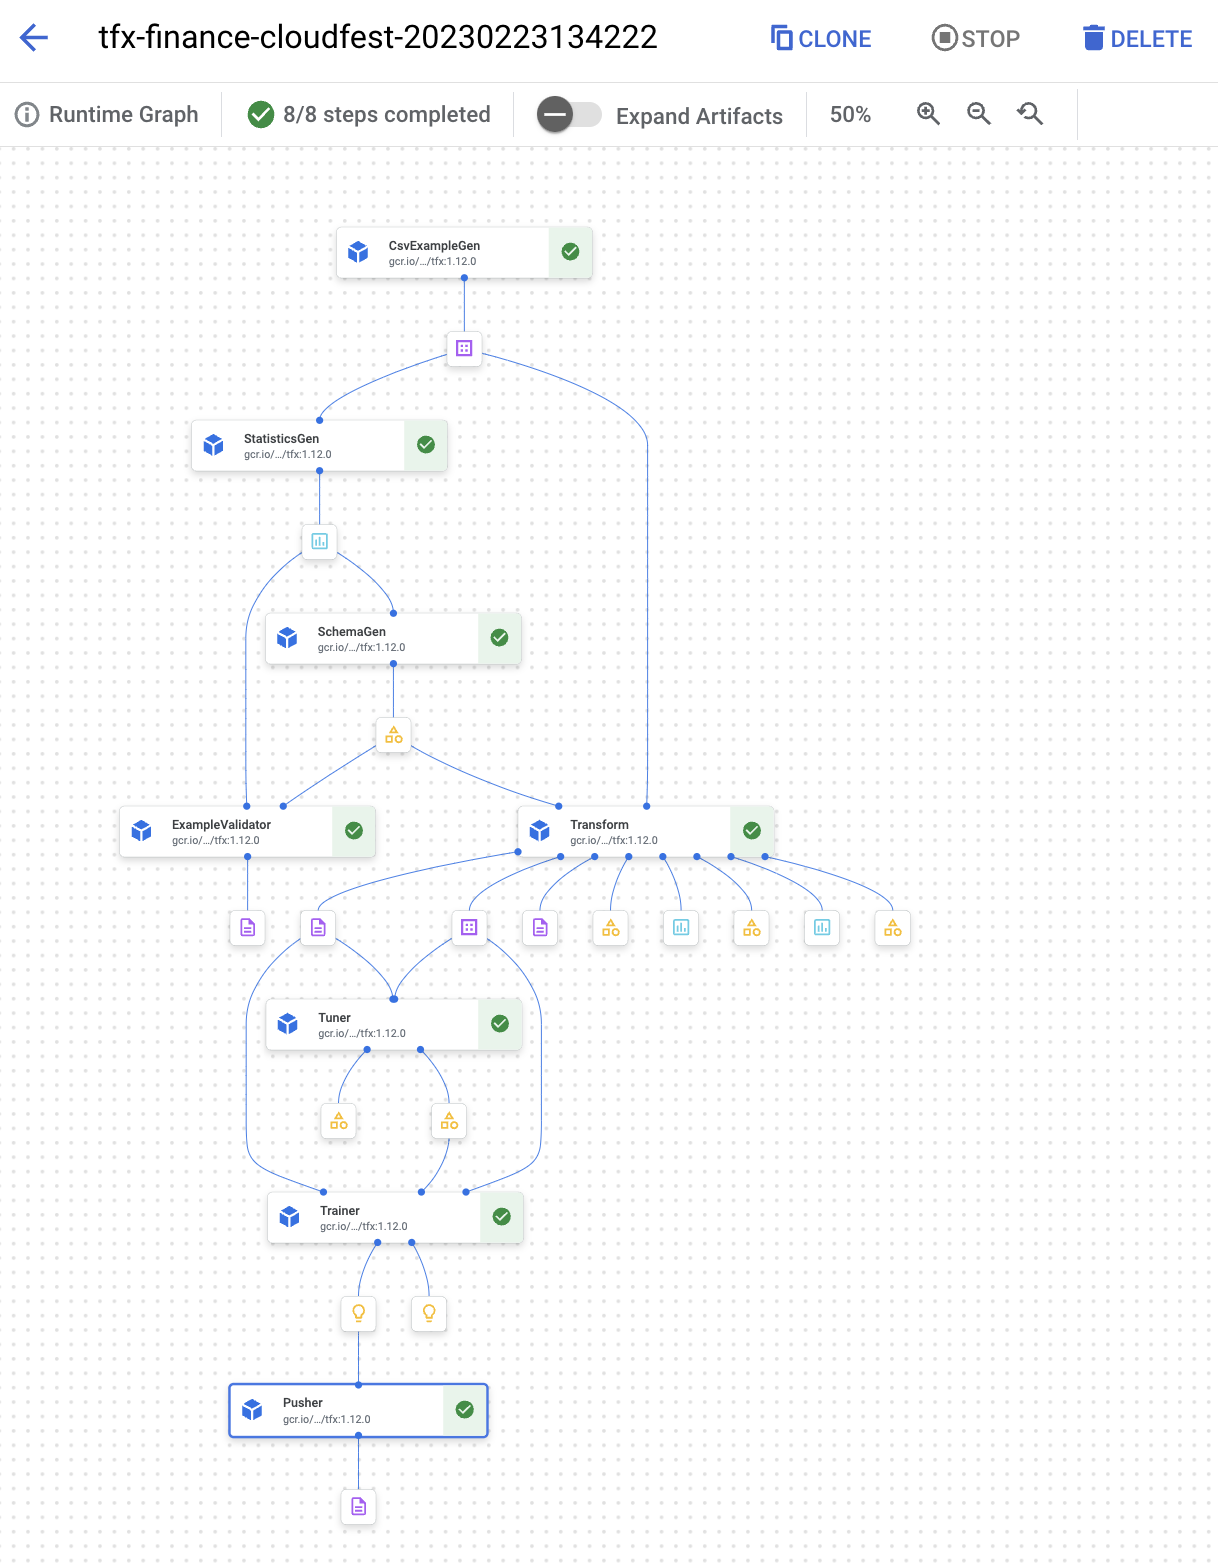

#### Test Vertex AI - Deployed Model

In [142]:
%%writefile payload.json

{
   "instances":[
      {
         "DIFGRIRV":-100.0,
         "NODLIR":90.0,
         "VSTATU":1,
         "NODLGR":0.0,
         "DIFGRIRD":-80.0,
         "VPATD":30,
         "WERKS":"ML01",
         "EKORG":1,
         "TOTGRQTY":0.0,
         "SCENARIO":3,
         "TOTIRQTY":80.0,
         "KTOKK":1,
         "EKGRP":"A"
      }
   ]
}

Overwriting payload.json


In [143]:
%%bash
ENDPOINT_ID="5770223828428914688"
PROJECT_ID="208069485237" ##PROJECT - number
INPUT_DATA_FILE="payload.json"

curl \
-X POST \
-H "Authorization: Bearer $(gcloud auth print-access-token)" \
-H "Content-Type: application/json" \
https://us-central1-aiplatform.googleapis.com/v1/projects/${PROJECT_ID}/locations/us-central1/endpoints/${ENDPOINT_ID}:predict \
-d "@${INPUT_DATA_FILE}"

{
  "predictions": [
    [
      0.998459578
    ]
  ],
  "deployedModelId": "6047555845326110720",
  "model": "projects/208069485237/locations/us-central1/models/4027293389241188352",
  "modelDisplayName": "v1677162691",
  "modelVersionId": "1"
}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   575    0   248  100   327    288    380 --:--:-- --:--:-- --:--:--   667
